Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
20/20 [==============================] - 5s 5ms/step - loss: 0.1038
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0565
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0517
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0502
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0525
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 10/10
1/1 [==============================] - 1s 907ms/step


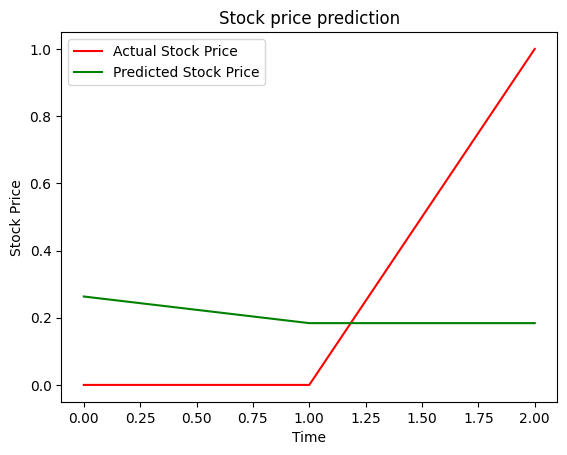

Root Mean Squared Error (RMSE): 0.48862743075616305


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Colab-Notebooks/")
os.getcwd()

df = pd.read_csv("/content/drive/My Drive/Colab-Notebooks/MSFT.csv")
df.head()

#Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Removing non-numeric characters and convert numerical columns to float
#for col in df.columns[1:]:
 #   df[col] = df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)

import pandas as pd

# Assuming df is your DataFrame
# Removing non-numeric characters and convert numerical columns to float
for col in df.columns[1:]:
    if df[col].dtype == 'object':  # Check if column is of string type
        df[col] = df[col].str.replace(r'[^\d.]', '', regex=True)
        df[col] = df[col].astype(float)

# Drop rows with missing values
df.dropna(inplace=True)

#Normalizing the numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns='Date'))

# Creating time series data with three-day windows
lookback = 3
generator = TimeseriesGenerator(scaled_data, scaled_data, length=lookback, batch_size=1)


train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

#for LSTM model
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

#for training and testing data
X_train, y_train = create_sequences(train, lookback)
X_test, y_test = create_sequences(test, lookback)

#Reshaping the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

Y_predictions = model.predict(X_test)
# Reshape Y_predictions to match the shape of X_train
Y_predictions = Y_predictions.reshape(-1, 1)


plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(Y_predictions, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

rmse = np.sqrt(np.mean(((Y_predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)



